In [1]:
import math
import time

import matplotlib.pyplot as plt
import torch
from torch.distributions import MultivariateNormal
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons


class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


def exact_div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = torch.func.jacrev(u)
    return lambda x, *args: torch.trace(J(x))


def div_fn_hutch_trace(u):
    def div_fn(x, eps):
        _, vjpfunc = torch.func.vjp(u, x)
        return (vjpfunc(eps)[0] * eps).sum()

    return div_fn


class cnf_wrapper(torch.nn.Module):
    """Wraps model to a torchdyn compatible CNF format.
    Appends an additional dimension representing the change in likelihood
    over time.
    """

    def __init__(self, model, likelihood_estimator="exact"):
        super().__init__()
        self.model = model
        self.div_fn, self.eps_fn = self.get_div_and_eps(likelihood_estimator)

    def get_div_and_eps(self, likelihood_estimator):
        if likelihood_estimator == "exact":
            return exact_div_fn, None
        if likelihood_estimator == "hutch_gaussian":
            return div_fn_hutch_trace, torch.randn_like
        if likelihood_estimator == "hutch_rademacher":
            def eps_fn(x):
                return torch.randint_like(x, low=0, high=2).float() * 2 - 1.0

            return div_fn_hutch_trace, eps_fn
        raise NotImplementedError(
            f"likelihood estimator {likelihood_estimator} is not implemented"
        )

    def forward(self, t, x, *args, **kwargs):
        t = t.squeeze()
        x = x[..., :-1]

        def vecfield(y):
            return self.model(torch.cat([y, t[None]]))

        if self.eps_fn is None:
            div = torch.vmap(self.div_fn(vecfield))(x)
        else:
            div = torch.vmap(self.div_fn(vecfield))(x, self.eps_fn(x))
        dx = self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))
        return torch.cat([dx, div[:, None]], dim=-1)

In [2]:
class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)

In [3]:
def sample_conditional_pt(x0, x1, t, sigma):
    """
    Draw a sample from the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    xt : Tensor, shape (bs, *dim)

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon


def compute_conditional_vector_field(x0, x1):
    """
    Compute the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch

    Returns
    -------
    ut : conditional vector field ut(x1|x0) = x1 - x0

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    return x1 - x0


class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


def plot_trajectories(traj):
    """Plot trajectories of some selected samples."""
    n = 2000
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
    plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
    plt.xticks([])
    plt.yticks([])
    plt.show()


def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data


def sample_moons(n):
    x0, _ = generate_moons(n, noise=0.2)
    return x0 * 3 - 1


def sample_8gaussians(n):
    return eight_normal_sample(n, 2, scale=5, var=0.1).float()

True
12.6
1
0
NVIDIA GeForce RTX 3080
Using device: cuda


D:\DGM\.venv\Lib\site-packages\torch\autograd\graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


5000: loss 2.735 time 1443.59


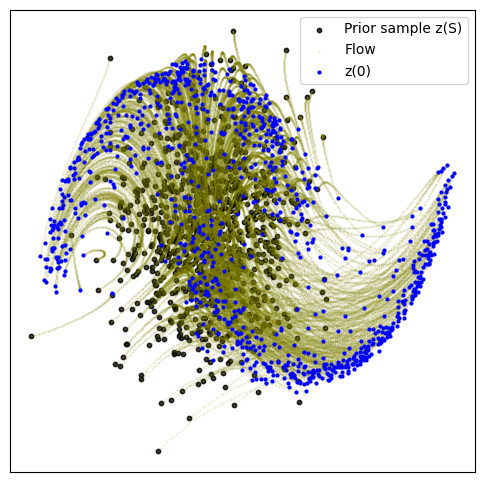

10000: loss 3.126 time 1438.77


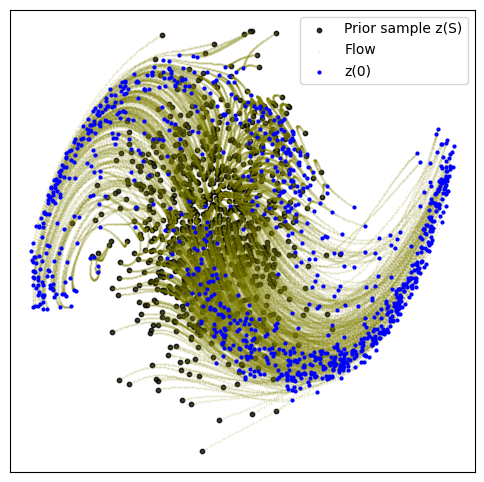

15000: loss 2.786 time 1379.69


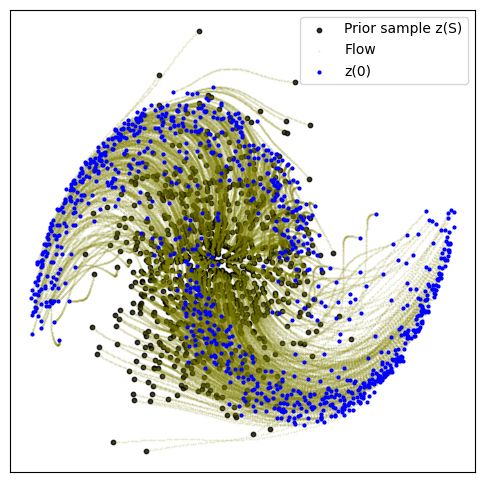

20000: loss 2.652 time 1367.40


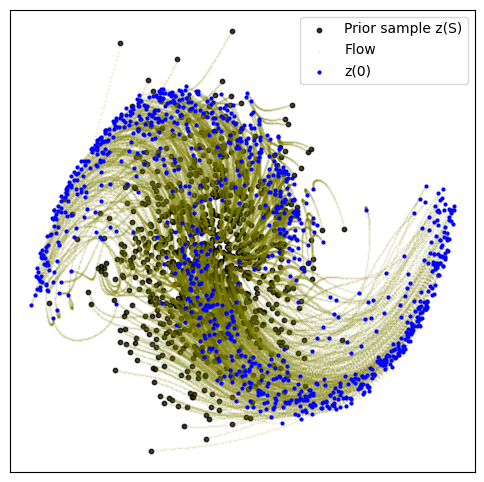

CPU times: total: 1h 33min 20s
Wall time: 1h 33min 49s


In [4]:
%%time

torch.cuda.empty_cache()  # 清空显存缓存
torch.backends.cudnn.benchmark = True  # 对卷积加速有用
print(torch.cuda.is_available())  # 应该返回 True
print(torch.version.cuda)  # 显示 CUDA 版本
print(torch.cuda.device_count())  # 显示 GPU 个数
print(torch.cuda.current_device())  # 当前设备索引
print(torch.cuda.get_device_name(0))  # 设备名称

# 检查 CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# 超参数
dim = 2
batch_size = 256
steps = 100
total_steps = 20000

# 模型
model = MLP(dim=dim, time_varying=True).to(device)
prior = MultivariateNormal(
    torch.zeros(dim, device=device),
    torch.eye(dim, device=device)
)
optimizer = torch.optim.Adam(model.parameters())

# CNF 和 NODE
cnf = NeuralODE(
    cnf_wrapper(model, likelihood_estimator="exact"),
    solver="euler",
    sensitivity="adjoint"
)
node = NeuralODE(
    torch_wrapper(model),
    solver="euler",
    sensitivity="adjoint"
)

# 训练
start = time.time()
for k in range(total_steps):
    optimizer.zero_grad()

    # 生成数据并放到 GPU
    x1 = sample_moons(batch_size).to(device)

    # 初始化 log-likelihood 列
    x1_with_ll = torch.cat([x1, torch.zeros(batch_size, 1, device=device)], dim=-1)

    # CNF 反向积分，结果仍在 GPU
    x0_with_ll = cnf.trajectory(x1_with_ll, t_span=torch.linspace(1, 0, steps + 1, device=device))[
        -1
    ]

    # 计算 log-probability
    logprob = prior.log_prob(x0_with_ll[..., :-1]) + x0_with_ll[..., -1]

    # 损失与优化
    loss = -torch.mean(logprob)
    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k + 1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end

        with torch.no_grad():
            traj = node.trajectory(
                torch.randn(1024, 2, device=device),
                t_span=torch.linspace(0, 1, steps + 1, device=device),
            )
            plot_trajectories(traj.cpu().numpy())
